# Setup

In [12]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize

## Load data

In [13]:
# Load dataframe
bd = pd.read_pickle("./data/batting_data_ch3.pkl")

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0, beta0 = np.load(f)

### Figure 7.1
Relationship between the number of at-bats (AB) and the raw batting average (H / AB) across all players with at least 10 at-bats.

In [14]:
import statsmodels.api as sm

def run_regression(xx,yy):
    X = sm.add_constant(xx)#, prepend=False)
    ols = sm.OLS(yy,X)
    ols_result = ols.fit()
    return ols_result

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/144107175.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")


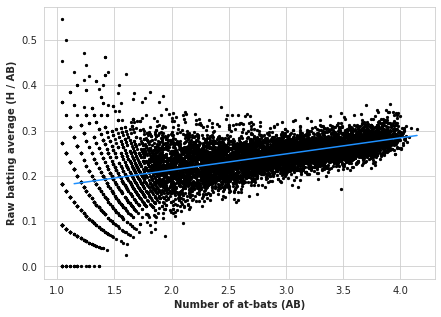

In [15]:
# Get data and run regression
xx,yy = bd.loc[bd.AB>10,"AB"],bd.loc[bd.AB>10,"Avg"]
ols_result = run_regression(np.log10(xx),yy)

# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    xvals = np.linspace(0,bd.AB.max(),1000)
    ax.scatter(np.log10(xx),yy,color="k",s=5)
    ax.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    # Clean up
    ax.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax.set_ylabel("Raw batting average (H / AB)",fontweight="bold")

### Figure 7.2 
Scatter plot of the relationship AB has with raw batting average (left) and with empirical Bayes shrunken estimates (right). The prior mean .261 is shown as a horizontal dashed red line, -fit lines are shown in blue.

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/3104977297.py:13: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/3104977297.py:25: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")


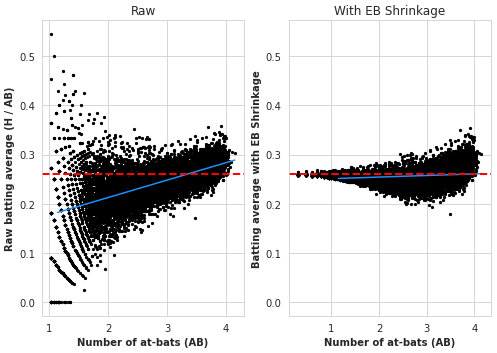

In [16]:
prior_mean = stats.beta(alpha0,beta0).mean()

with sns.axes_style("whitegrid"):
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(7,5)
    
    # Same as 7.1 
    xx,yy = bd.loc[bd.AB>10,"AB"],bd.loc[bd.AB>10,"Avg"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax1.scatter(np.log10(xx),yy,color="k",s=5)
    ax1.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax1.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax1.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax1.set_ylabel("Raw batting average (H / AB)",fontweight="bold")
    ax1.title.set_text("Raw")

    # Same as 7.1 
    xx,yy = bd.loc[bd.AB>1,"AB"],bd.loc[bd.AB>1,"eb estimate Avg"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax2.scatter(np.log10(xx),yy,color="k",s=5)
    ax2.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax2.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax2.set_ylabel("Batting average with EB Shrinkage",fontweight="bold")
    ax2.title.set_text("With EB Shrinkage")

    plt.tight_layout()
    

## 7.2 Accounting for AB in the model

In [17]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    # Get H/AB 
    k, n = args # H, AB

    # The initial model assumed a fixed (alpha, beta):
    #        a, b = params[0], params[1]

    # Here, we take in the initial values of (mu_0, mu_ab, and sigma_0) to compute (alpha, beta):
    mu_0, mu_AB, sigma_0 = params
    mu_i = mu_0 + mu_AB*np.log(n)
    a = mu_i / sigma_0
    b = (1-mu_i)/sigma_0
    
    # Log pdf
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    mask = np.isfinite(logpdf)
    return -logpdf[mask].sum()#-np.sum(logpdf) #


In [18]:
from scipy.optimize import minimize

min_atbat = 0

# I am going to cheat here and use the values from the book as initial parameters since MLE is probably not the best choice here.
init_params = [.1426,.0153,np.exp(-6.2935)]

# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(bd.loc[bd.AB > min_atbat,'H'], bd.loc[bd.AB > min_atbat,'AB']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000},bounds=[(0, 0.4), (0.001, 0.5),(.0001,.1)])
            
print(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57205D+04    |proj g|=  1.42600D-01

At iterate    1    f=  3.57201D+04    |proj g|=  4.84716D-01

At iterate    2    f=  3.57185D+04    |proj g|=  2.57566D-01

At iterate    3    f=  3.57183D+04    |proj g|=  2.57544D-01

At iterate    4    f=  3.57183D+04    |proj g|=  2.57528D-01

At iterate    5    f=  3.57183D+04    |proj g|=  2.57393D-01

At iterate    6    f=  3.57182D+04    |proj g|=  2.57129D-01

At iterate    7    f=  3.57181D+04    |proj g|=  2.56722D-01

At iterate    8    f=  3.57181D+04    |proj g|=  4.84860D-01

At iterate    9    f=  3.57181D+04    |proj g|=  4.84860D-01
      fun: 35718.09239452977
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.14551915, -0.33760443,  0.41909516])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev

In [19]:
print(result)

      fun: 35718.09239452977
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.14551915, -0.33760443,  0.41909516])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([0.14348183, 0.01514047, 0.00175561])


In [20]:
def get_alpha0_beta0(params,ABs=[]):
    # Convert to list if not lsit
    ABs = ABs if isinstance(ABs, list) else [ABs]
    # Get params from MLE 
    # mu, mu_AB, sigma = .1426,.0153,np.exp(-6.2935)
    mu, mu_AB, sigma = params
    # sigma = np.exp(sigma)
    # Initialize and loop through each AB value
    alpha0, beta0 = [],[]
    for AB in ABs:
        # Update alpha0 and beta0
        mu_i = (mu + mu_AB*np.log(AB)) if AB > 0 else mu
        a = mu_i / sigma
        b = (1-mu_i)/sigma
        alpha0.append(mu_i/sigma)
        beta0.append((1-mu_i)/sigma)

    return list(tuple(zip(alpha0, beta0))) # returns pairs of alpha0,beta0 values

# Figure 7.3 
The density of the prior distribution for a player with particular numbers of at-bats.

[(81.72784566241113, 487.8763028496167), (101.5855095497204, 468.0186389623075), (121.44317343702966, 448.1609750749982), (141.30083732433894, 428.30331118768896), (161.1585012116482, 408.4456473003797)]


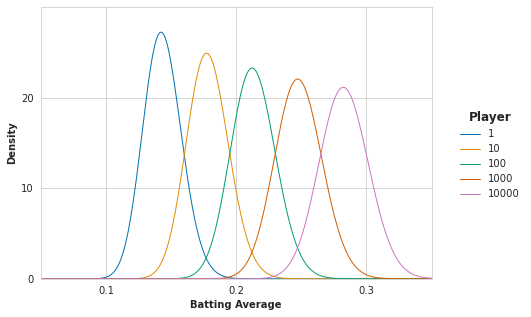

In [21]:
# Which ABs
ABs = [1,10,100,1000,10000]

beta_params = get_alpha0_beta0(result.x,ABs)
print(beta_params)
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    clrs = sns.color_palette("colorblind",n_colors=len(ABs))

    # Make distributions for prior
    x = np.linspace(0,1,1000)

    # ax.plot(x, stats.beta.pdf(x,alpha0,beta0),color='k',linestyle='--')
    for (vals,clr,AB) in zip(beta_params,clrs,ABs):
        a0,b0 = vals
        ax.plot(x,stats.beta.pdf(x,a0,b0),color=clr,lw=1,label="{}".format(AB))
    
    # Add legend and clean up
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("Player",prop = {'size':12,'weight': "bold"})
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    ax.set_xticks([0.1,0.2,0.3])
    ax.set_xlim(0.05,.35)
    ax.set_yticks([0,10,20])
    ax.set_ylim(0,30)


In [22]:
def new_eb_estimate(row,params):

    # Get H and AB for each row
    H,AB = row.H, row.AB
    
    # Get values from MLE results
    mu, mu_AB, sigma = params

    # Update alpha0 and beta0
    mu_i = (mu + mu_AB*np.log(AB)) if AB > 0 else mu
    a = mu_i / sigma
    b = (1-mu_i)/sigma
    alpha0 = mu_i/sigma
    beta0 = (1-mu_i)/sigma

    # Update alpha1 and beta1
    alpha1 = alpha0 + H
    beta1  = beta0 + (AB - H)

    # New eb estimate
    new_eb_estimate = alpha1 / (alpha1 + beta1)

    # Update data
    row["alpha0"] = alpha0 
    row["beta0"]  = beta0 
    row["alpha1"] = alpha1
    row["beta1"]  = beta1
    row["new_eb_estimate"] = new_eb_estimate

    return row

bd = bd.loc[bd.AB>0,:].apply(lambda row: new_eb_estimate(row,result.x),axis=1)



### Figure 7.4

The relationship between the original empirical Bayes shrunken estimates and the values under the beta-binomial regression model.

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/2840462.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(splot,ticks=cbar_ticks)


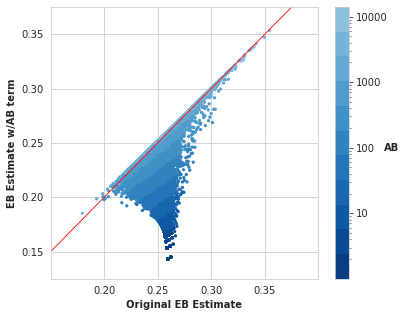

In [23]:
import matplotlib as mpl

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot()
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])
    # Plot scatter 
    splot = ax.scatter(bd["eb estimate Avg"],bd["new_eb_estimate"],c=bd["AB"],s=5,cmap=cmap,norm=mpl.colors.LogNorm())
    # Plot new EB estimate = old EB estimate
    ax.plot(np.linspace(0.1,.4,1000),np.linspace(.1,.4,1000),color='r',lw=0.85)    
    # Clean up
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot,ticks=cbar_ticks)
    cbar.ax.set_yticklabels(list(map(str, cbar_ticks)))
    cbar.set_label("AB",rotation=0,fontweight="bold")
    ax.set_ylim(0.125,0.375)
    ax.set_yticks(np.arange(0.15,0.40,step=0.05))
    ax.set_xticks(np.arange(0.2,0.40,step=0.05))
    ax.set_xlim(.15,.40)
    ax.set_xlabel("Original EB Estimate",fontweight="bold")
    ax.set_ylabel("EB Estimate w/AB term",fontweight="bold") 

### Figure 7.5
The relationship between AB and the estimate for three methods: raw batting average, shrunken batting average, and averages shrunk towards a relationship found through regression.

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/3639746093.py:18: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/3639746093.py:31: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/3639746093.py:47: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")


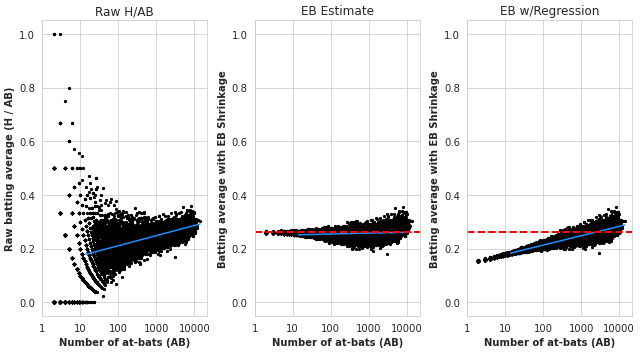

In [24]:
prior_mean = stats.beta(alpha0,beta0).mean()

min_atbat=1

# Set xticks for plots
xticks = [1,10,100,1000,10000]

with sns.axes_style("whitegrid"):
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(9,5)
    
    # Same as 7.1 
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"Avg"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax1.scatter(np.log10(xx),yy,color="k",s=5)
    ax1.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    # Clean up
    ax1.set_xticks(np.log10(xticks))
    ax1.set_xticklabels(list(map(str,xticks)))
    ax1.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax1.set_ylabel("Raw batting average (H / AB)",fontweight="bold")
    ax1.title.set_text("Raw H/AB")

    # EB estimate
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"eb estimate Avg"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax2.scatter(np.log10(xx),yy,color="k",s=5)
    ax2.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax2.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(ax1.get_xticklabels())
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax2.set_ylabel("Batting average with EB Shrinkage",fontweight="bold")
    ax2.title.set_text("EB Estimate")


    # NEW EB estimate w/AB taken into account
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"new_eb_estimate"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax3.scatter(np.log10(xx),yy,color="k",s=5)
    ax3.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax3.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax3.set_xticks(ax1.get_xticks())
    ax3.set_xticklabels(ax1.get_xticklabels())
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax3.set_ylabel("Batting average with EB Shrinkage",fontweight="bold")
    ax3.title.set_text("EB w/Regression")


    plt.tight_layout()
    

## Section 7.3 V2
Now let's try it again but instead of using MLE to find the parameters, we will try using Markov chain Monte Carlo (MCMC) to estimate the parameters of our beta-binomial model. We will first try it with out the AB regression just as a sanity check and then do it again with the added AB regression. 

In [25]:
import pymc as pm
import arviz as az

In [26]:
# Instance of pymc model
with pm.Model() as model_naive:
    # Define alpha and beta as coming from uniform distribution
    alpha0 = pm.Uniform('alpha',10,200)
    beta0  = pm.Uniform('beta',150,350)

    # Beta-binomial distribution
    X0 = pm.BetaBinomial("X",alpha=alpha0,beta=beta0,observed=bd.loc[:,"H"].to_numpy(),n=bd.loc[:,"AB"].to_numpy())

    # Inference! Perform sampling
    idata = pm.sample(2000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 102 seconds.
The acceptance probability does not match the target. It is 0.8855, but should be close to 0.8. Try to increase the number of tuning steps.


In [27]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,74.562,1.907,71.091,78.141,0.055,0.039,1188.0,1167.0,1.0
beta,223.033,5.568,212.882,233.427,0.161,0.114,1196.0,1174.0,1.0


Let's see how these compare to the previous values we computed using MLE:

In [28]:
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0_mle, beta0_mle = np.load(f)

summary = pm.summary(idata)
summary.insert(0,"ML Estimate",[alpha0_mle,beta0_mle])
summary


,ML Estimate,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,89.733185,74.562,1.907,71.091,78.141,0.055,0.039,1188.0,1167.0,1.0
beta,255.130635,223.033,5.568,212.882,233.427,0.161,0.114,1196.0,1174.0,1.0


The MLE values are quite similar to the ones obtained through MCMC. Out of curiousity, let's try it again but assume that they paramters are from a normal distribution (this may not be entirely correct considering that alpha and beta cannot be < 0). 

In [29]:
# Instance of pymc model
with pm.Model() as model_naive:
    # Define alpha and beta as coming from uniform distribution
    alpha0 = pm.Normal('alpha',100,sigma=25)
    beta0  = pm.Normal('beta',200,sigma=50)

    # Beta-binomial distribution
    X0 = pm.BetaBinomial("X",alpha=alpha0,beta=beta0,observed=bd.loc[:,"H"].to_numpy(),n=bd.loc[:,"AB"].to_numpy())

    # Inference! Perform sampling
    idata = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 90 seconds.
The acceptance probability does not match the target. It is 0.8892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
summary2 = pm.summary(idata)
summary2.insert(0,"ML Estimate",[alpha0_mle,beta0_mle])
summary2.insert(1,"Uniform assumption",summary["mean"])
summary2

,ML Estimate,Uniform assumption,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,89.733185,74.562,74.552,1.909,71.004,78.063,0.056,0.040,1147.0,1137.0,1.01
beta,255.130635,223.033,223.004,5.574,212.813,233.435,0.165,0.117,1150.0,1184.0,1.01


Both estimates are almost identical. It is important to note that we only drew 2000 samples. We should probably re-run it with a higher number of samples and then we can ignore burn-in values.

For now, we can just stick with the last one so we don't have to run it again.  We can plot the posterior distribution of our parameters and the individual samples we drew.

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

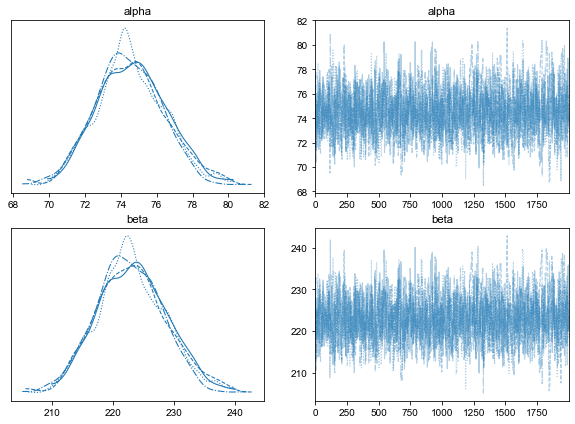

In [31]:
az.plot_trace(idata, figsize=(10, 7))

Now lets try it with the regression for AB.

In [40]:
n_samples = 30000
H,AB = bd.loc[:,"H"].to_numpy(), bd.loc[:,"AB"].to_numpy()
# Create the probability from the logistic function
with pm.Model() as model1:
    # Define parameters for mu, mu_ab
    mu_0 = pm.Uniform('mu_o', lower=0.0, upper=1.0)
    mu_ab = pm.Uniform('mu_ab', lower=0.0, upper=1.0)
    # Kappa => 1/sigma
    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', pm.math.exp(kappa_log))

    # Get beta-binomial models
    X1 = pm.BetaBinomial('X', alpha=(mu_0+ mu_ab * pm.math.log(AB))*kappa, beta=(1-(mu_0 + mu_ab * pm.math.log(AB)))*kappa, n=AB, observed=H, shape=AB.shape[0])
    # Sample!
    idata1 = pm.sample(n_samples, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 32100
Interrupted at 32,099 [16%]: Average Loss = 47,553
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_o, mu_ab, kappa_log]


Sampling 4 chains for 1_000 tune and 30_000 draw iterations (4_000 + 120_000 draws total) took 1626 seconds.
The acceptance probability does not match the target. It is 0.9055, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89, but should be close to 0.8. Try to increase the number of tuning steps.


In [41]:
pm.summary(idata1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_o,0.143,0.002,0.140,0.146,0.000,0.000,40115.0,46101.0,1.0
mu_ab,0.015,0.000,0.015,0.016,0.000,0.000,40030.0,46744.0,1.0
kappa_log,6.344,0.027,6.293,6.396,0.000,0.000,58011.0,52635.0,1.0
kappa,568.999,15.642,539.983,598.520,0.065,0.046,58011.0,52635.0,1.0


Get values from simulation.

array([[<AxesSubplot:title={'center':'mu_o'}>,
        <AxesSubplot:title={'center':'mu_o'}>],
       [<AxesSubplot:title={'center':'mu_ab'}>,
        <AxesSubplot:title={'center':'mu_ab'}>],
       [<AxesSubplot:title={'center':'kappa_log'}>,
        <AxesSubplot:title={'center':'kappa_log'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>]], dtype=object)

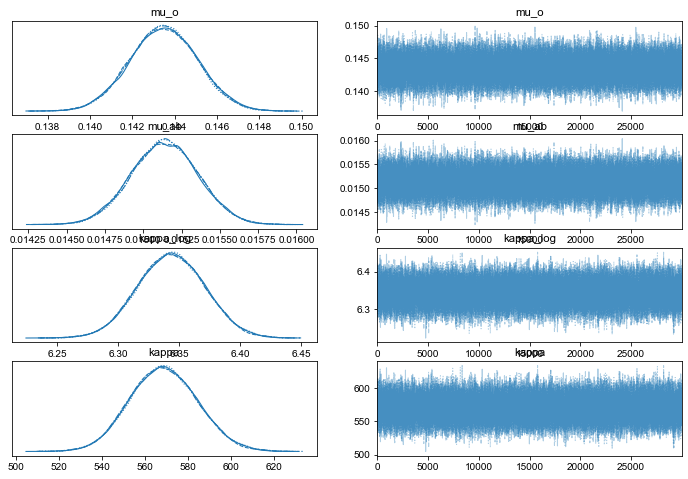

In [42]:
az.plot_trace(idata1)

In [45]:
mu_mcmc    = idata1.posterior["mu_o"].mean(("chain","draw")).to_numpy()
mu_ab_mcmc = idata1.posterior["mu_ab"].mean(("chain","draw")).to_numpy()
sigma_mcmc = 1/idata1.posterior["kappa"].mean(("chain","draw")).to_numpy()
print(mu_mcmc,mu_ab_mcmc,sigma_mcmc)

0.14348079078241008 0.015140691689290199 0.0017574710129629198


In [46]:
bd = bd.rename(columns={"new_eb_estimate":"eb estimate MLE"})
bd = bd.loc[bd.AB>0,:].apply(lambda row: new_eb_estimate(row,(mu_mcmc,mu_ab_mcmc,sigma_mcmc)),axis=1)
bd = bd.rename(columns={"new_eb_estimate":"eb estimate MCMC"})

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/1237163833.py:18: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/1237163833.py:31: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/1237163833.py:47: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_82899/1237163833.py:63: RuntimeWarning: divide by zero encountered in log10
  ax4.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")


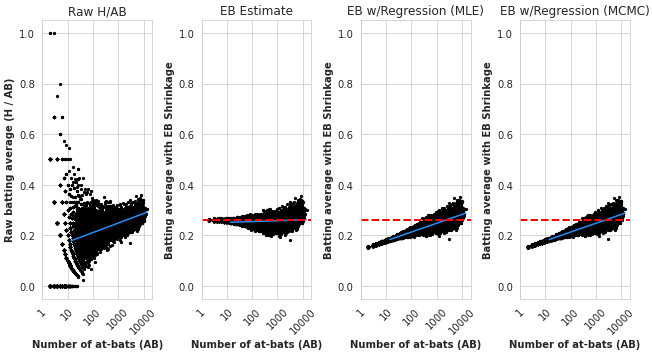

In [50]:
prior_mean = stats.beta(alpha0_mle,beta0_mle).mean()

min_atbat=1

# Set xticks for plots
xticks = [1,10,100,1000,10000]

with sns.axes_style("whitegrid"):
    # Create figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
    fig.set_size_inches(9,5)
    
    # Same as 7.1 
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"Avg"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax1.scatter(np.log10(xx),yy,color="k",s=5)
    ax1.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    # Clean up
    ax1.set_xticks(np.log10(xticks))
    ax1.set_xticklabels(list(map(str,xticks)),rotation=45)
    ax1.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax1.set_ylabel("Raw batting average (H / AB)",fontweight="bold")
    ax1.title.set_text("Raw H/AB")

    # EB estimate
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"eb estimate Avg"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax2.scatter(np.log10(xx),yy,color="k",s=5)
    ax2.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax2.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xticklabels(ax1.get_xticklabels(),rotation=45)
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax2.set_ylabel("Batting average with EB Shrinkage",fontweight="bold")
    ax2.title.set_text("EB Estimate")


    # NEW EB estimate w/AB taken into account
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"eb estimate MLE"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax3.scatter(np.log10(xx),yy,color="k",s=5)
    ax3.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax3.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax3.set_xticks(ax1.get_xticks())
    ax3.set_xticklabels(ax1.get_xticklabels(),rotation=45)
    ax3.set_ylim(ax1.get_ylim())
    ax3.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax3.set_ylabel("Batting average with EB Shrinkage",fontweight="bold")
    ax3.title.set_text("EB w/Regression (MLE)")


    # NEW EB estimate w/AB taken into account
    xx,yy = bd.loc[bd.AB>min_atbat,"AB"],bd.loc[bd.AB>min_atbat,"eb estimate MCMC"]
    ols_result = run_regression(np.log10(xx),yy)
    # Plot
    ax4.scatter(np.log10(xx),yy,color="k",s=5)
    ax4.plot(np.log10(xvals),np.log10(xvals)*ols_result.params[1] + ols_result.params[0],color="dodgerblue")
    ax4.axhline(y=prior_mean,color="r",linestyle='--',lw=2)
    # Clean up
    ax4.set_xticks(ax1.get_xticks())
    ax4.set_xticklabels(ax1.get_xticklabels(),rotation=45)
    ax4.set_ylim(ax1.get_ylim())
    ax4.set_xlabel("Number of at-bats (AB)",fontweight="bold")
    ax4.set_ylabel("Batting average with EB Shrinkage",fontweight="bold")
    ax4.title.set_text("EB w/Regression (MCMC)")

    plt.tight_layout()
    

In [ ]:
# Save dataframe
bd.to_pickle("./data/batting_data_ch7.pkl")